# **Homework on Credit Risk**
## **Building an Application Scoring Model**

### **General Information**
- **Date assigned:** December 2, 2025  
- **Soft deadline:** 23:59 MSK, December 15, 2025  
- **Hard deadline:** 23:59 MSK, December 18, 2025  
- **Submission:** send your work to  
  \texttt{maria.vorobyova.ser@gmail.com}  
  with the subject format:
  \[
  \text{HSE\_CS\_[track]\_FullName}
  \]
  Example:
  \[
  \text{HSE\_CS\_PAD\_IVANOV\_IVAN\_IVANOVICH}
  \]

---

### **Grading and Penalties**
Maximum score: **10 points**

Late penalty:
\[
\text{Final Score} = 10 - \text{days late}
\]

Submission **after** the hard deadline is **not accepted**.

Work must be completed **independently**.  
Similar solutions → **plagiarism** → score **0**.

---

### **Score Reduction If**
- no comments in the notebook
- unclear or poorly written code
- incorrect analysis and conclusions

---

### **Task**
Build a scoring model estimating the **probability of default** at the **credit application stage**.

Follow the provided notebook strictly and complete every block.

---

### **Dataset**
Based on Kaggle competition:
\[
\text{Give Me Some Credit}
\]

Data source:  
https://www.kaggle.com/competitions/GiveMeSomeCredit/data  

Data description:  
**Data Dictionary.xlsx**



# **Work assignment:**
**1.Explatory Data Analysis - (Task weight: 20%)**

**2.Creating additional variables - (Task weight: 10%)**

**3. Model building (A logistic regression must be built on the WoE variables.)- (Task weight: 50%)**

**4. Using methods to reduce class imbalance - (Task weight: 20%)**

# **Submitting results:**

* Submit homework via the Yandex form as a link to your GitHub, where all files and code (Python) will be.
* GitHub must be open and the code must be working, without errors.
* Name the repository using the template (HW_4_2025-FirstName_LastName).
* Link to the Yandex form: https://forms.yandex.ru/u/68eece24505690c23425594c

We wish you good luck!✌

# Additional explanations for the task

In [ ]:
from google.colab import drive
import json
import zipfile

from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_dataset(from_kaggle: bool = False, local_zip: str = None) -> pd.DataFrame:
  """
  The function downloads data from Kaggle if from_kaggle=True.
  Otherwise it tries to read an archive either from a provided local path or from Google Drive.
  params:
      - from_kaggle: whether to download with Kaggle CLI
      - local_zip: optional absolute path to an existing GiveMeSomeCredit.zip
  return:
      - (train_df, test_df)
  """
  if local_zip is not None:
    zip_path = local_zip
  elif from_kaggle:
    import subprocess
    # requests Google Drive permission, ensure kaggle.json is available
    drive.mount('/content/drive')
    subprocess.run(['pip', 'install', 'kaggle', '-q'], check=True)
    subprocess.run(['mkdir', '-p', '/root/.kaggle'], check=True)
    subprocess.run(['cp', '/content/drive/MyDrive/Colab Notebooks/config/kaggle.json', '/root/.kaggle/'], check=True)
    subprocess.run(['chmod', '600', '/root/.kaggle/kaggle.json'], check=True)
    subprocess.run(['kaggle', 'competitions', 'download', '-c', 'GiveMeSomeCredit'], check=True)
    zip_path = 'GiveMeSomeCredit.zip'
  else:
    import subprocess
    subprocess.run(['pip', 'install', 'gdown', '-q'], check=True)
    subprocess.run(['gdown', '1MRYG6P6ScMTzTmXJlWdPdYQVNi04wLSm', '-O', 'GiveMeSomeCredit.zip'], check=True)
    zip_path = 'GiveMeSomeCredit.zip'
  # unpack archive
  zip_ref = zipfile.ZipFile(zip_path, 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('cs-training.csv')
  df_test = pd.read_csv('cs-test.csv')
  return df_train, df_test

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Business_hse/HW_4/cs-training.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Business_hse/HW_4/cs-test.csv')

In [ ]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# 1.Explatory Data Analysis. Максимально - (20%-2 балла)

- 0 points if the task is not completed
- 1 point if statistics are calculated and there are logical graphs (important, USEFUL graphs), but no conclusions are drawn
- 2 points if statistics are calculated and there are graphs (important, USEFUL graphs) and CONCLUSIONS are drawn (important, that the conclusions are correct)

In [ ]:
df = df_train.copy()

In [ ]:
if 'Unnamed: 0' in df.columns:
  df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column                               |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------------------------------+----------------+---------------+--------------+-------------+-------------|
| SeriousDlqin2yrs                     |              2 |        139974 |            0 |         0   | int64       |
| RevolvingUtilizationOfUnsecuredLines |         125728 |         10878 |            0 |         0   | float64     |
| age                                  |             86 |             1 |            0 |         0   | int64       |
| NumberOfTime30-59DaysPastDueNotWorse |             16 |        126018 |            0 |         0   | int64       |
| DebtRatio                            |         114194 |          4113 |            0 |         0   | float64     |
| MonthlyIncome                        |          13594 |          1634 |        29731 |        19.8 | float64     |
| NumberOfOpenCreditLinesAndLoans      |             58 |       

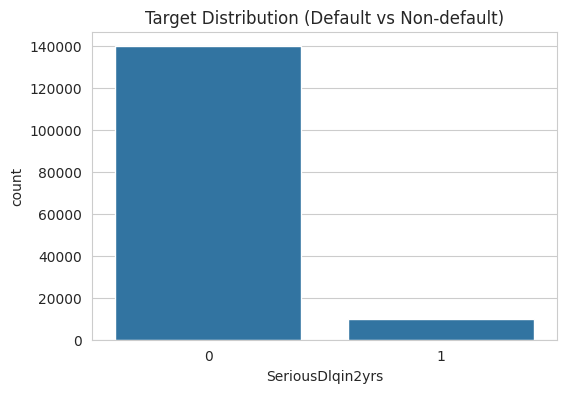

,proportion
SeriousDlqin2yrs,
0,0.93316
1,0.06684


In [ ]:
target = "SeriousDlqin2yrs"

plt.figure(figsize=(6,4))
sns.countplot(data=df, x=target)
plt.title("Target Distribution (Default vs Non-default)")
plt.show()

df[target].value_counts(normalize=True)

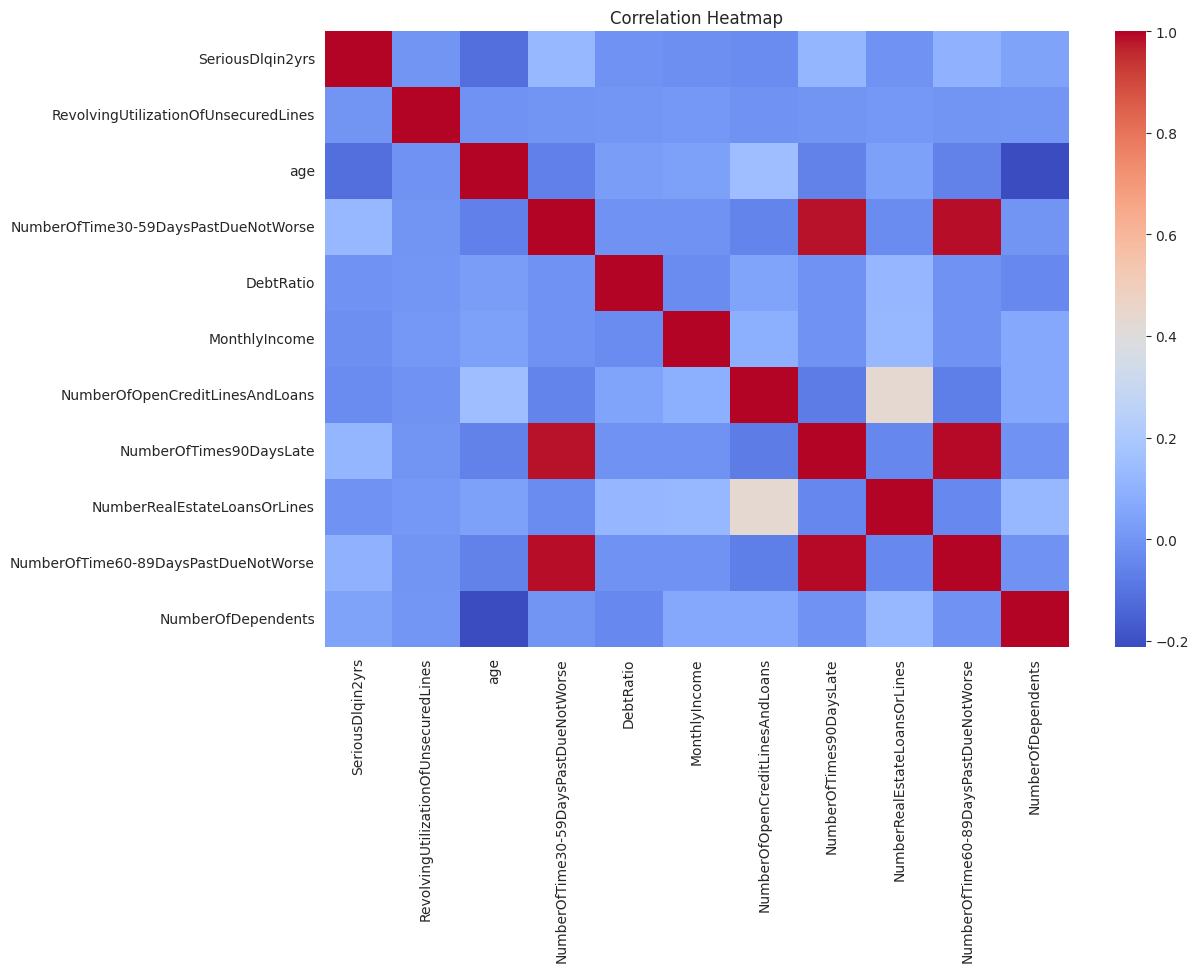

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
sns.histplot(df['age'], bins=30, kde=True, ax=axes[0, 1], color='steelblue')
axes[0, 1].set_title('Age distribution')

plt.show()

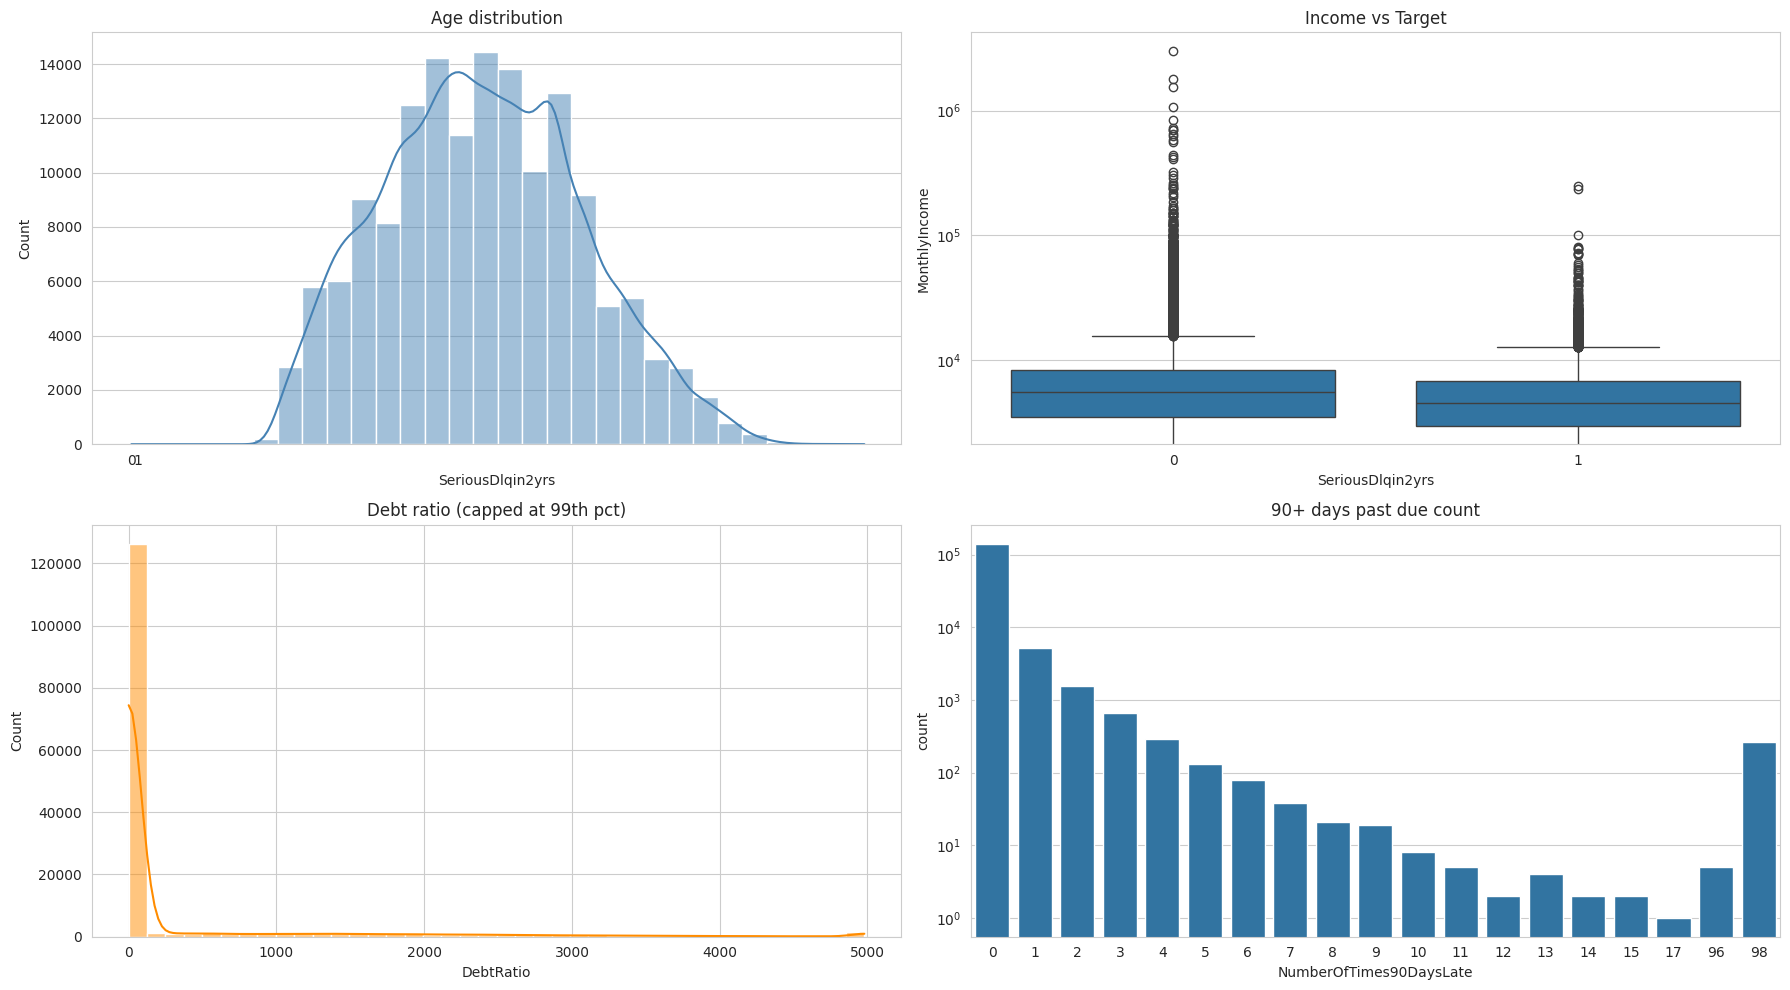

In [ ]:
# Visuals
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.barplot(x=df[target].value_counts().index, y=df[target].value_counts(normalize=True).values,
            palette='viridis', ax=axes[0, 0])

sns.histplot(df['age'], bins=30, kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Age distribution')

sns.boxplot(x=df[target], y=df['MonthlyIncome'], ax=axes[0, 1])
axes[0, 1].set_title('Income vs Target')
axes[0, 1].set_yscale('log')

sns.histplot(df['DebtRatio'].clip(upper=df['DebtRatio'].quantile(0.99)), bins=40, kde=True,
             ax=axes[1, 0], color='darkorange')
axes[1, 0].set_title('Debt ratio (capped at 99th pct)')

sns.countplot(x=df['NumberOfTimes90DaysLate'], ax=axes[1, 1])
axes[1, 1].set_title('90+ days past due count')
axes[1, 1].set_yscale('log')


plt.tight_layout()
plt.show()


# 2.Creating additional variables - (Task weight: 10%)

Be creative: the more variables, the higher the score! However, variables must be logical; illogical variables will not be accepted.

- 0 points if the task is not completed.
- 0.5 points - 2 additional variables created.
- 1 point - more than 3 variables created.


In [ ]:

df_fe = df.copy()

# Impute missing values with simple, robust statistics
income_median = df_fe['MonthlyIncome'].median()
dependents_mode = df_fe['NumberOfDependents'].mode()[0]
df_fe['MonthlyIncome'].fillna(income_median, inplace=True)
df_fe['NumberOfDependents'].fillna(dependents_mode, inplace=True)


In [ ]:

# Additional variables (>=4 for full points)
df_fe['log_income'] = np.log1p(df_fe['MonthlyIncome'])
df_fe['income_per_person'] = df_fe['MonthlyIncome'] / (df_fe['NumberOfDependents'] + 1)
df_fe['debt_to_income'] = df_fe['DebtRatio']  # already ratio, kept for clarity
# proportion of delinquency counts to total credit lines
lines = df_fe['NumberOfOpenCreditLinesAndLoans'].replace(0, 1)
df_fe['late_ratio'] = (df_fe['NumberOfTimes90DaysLate'] + df_fe['NumberOfTime60-89DaysPastDueNotWorse'] + df_fe['NumberOfTime30-59DaysPastDueNotWorse']) / lines
# utilization scaled by income proxy
df_fe['util_times_income'] = df_fe['RevolvingUtilizationOfUnsecuredLines'] * df_fe['MonthlyIncome']
# binary high risk flag
_dfq = df_fe[['NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse']].sum(axis=1)
df_fe['ever_late'] = (_dfq > 0).astype(int)

print('Engineered columns added:', [c for c in df_fe.columns if c not in df.columns])


Engineered columns added: ['log_income', 'income_per_person', 'debt_to_income', 'late_ratio', 'util_times_income', 'ever_late']


In [ ]:


df_fe[[target]].join(df_fe[[c for c in df_fe.columns if c not in [target]]]).head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,log_income,income_per_person,debt_to_income,late_ratio,util_times_income,ever_late
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,9.118335,3040.0,0.802982,0.153846,6987.074674,1
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,7.863651,1300.0,0.121876,0.000000,2488.592649,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,8.020599,3042.0,0.085113,1.000000,2002.183986,1
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,8.101981,3300.0,0.036050,0.000000,771.572261,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,11.060196,63588.0,0.024926,0.142857,57689.538967,1


# 3. Model building - (Task weight: 50%)
A logistic regression must be built on the WoE variables.

- If any other model is built, the score is 0.

In [ ]:
# Utility: evaluation helpers

def evaluate_model(model, X_train, y_train, X_test, y_test, name='model'):
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  proba = model.predict_proba(X_test)[:, 1]
  roc = roc_auc_score(y_test, proba)
  f1 = f1_score(y_test, preds)
  precision, recall, _ = precision_recall_curve(y_test, proba)
  pr_auc = auc(recall, precision)
  print(f'[{name}] ROC-AUC={roc:.4f} | F1={f1:.4f} | PR-AUC={pr_auc:.4f}')
  print(confusion_matrix(y_test, preds))
  return {'model': name, 'roc_auc': roc, 'f1': f1, 'pr_auc': pr_auc}

random_state = 42

# placeholders (populated after WoE transformation below)
X_train = X_test = y_train = y_test = None

A WoE transformation must be calculated - maximum 3 points.

The WoE calculation must be done in two steps:

Step 1. Fine Classification (1 point). Splitting into a large number of bins (intervals).
- Typically, interval variables are divided into 20, 30, and so on intervals.
- For categorical variables, one category per group.
- Next, calculate the WoE for each group.

Step 2. Coarse Classification (2 points). Consolidating the intervals obtained in Step 1. The result should be no more than 5-10 intervals.
- Typically, groups with similar WoE values ​​are combined.
- The WoE must be monotonic, meaning that after your combination, the result must be interpretable (it is necessary to graphically demonstrate that the WoE is monotonic).


In [ ]:
# WoE binning (fine -> coarse), IV calculation, transformation
smooth = 0.5  # Laplace smoothing to avoid zero divisions

def calc_bin_stats(bin_series: pd.Series, y: pd.Series, total_bad: int, total_good: int, categorical: bool):
  data = pd.DataFrame({'bin': bin_series, 'y': y})
  grouped = data.groupby('bin')
  rows = []
  for b, g in grouped:
    bad = g['y'].sum()
    good = g.shape[0] - bad
    bad_rate = (bad + smooth) / (total_bad + smooth * grouped.ngroups)
    good_rate = (good + smooth) / (total_good + smooth * grouped.ngroups)
    woe = np.log(good_rate / bad_rate)
    iv = (good_rate - bad_rate) * woe
    if categorical:
      left, right = b, b
    else:
      left, right = b.left, b.right
    rows.append({'bin': b, 'left': left, 'right': right, 'count': g.shape[0], 'bad': bad, 'good': good,
                 'bad_rate': bad_rate, 'good_rate': good_rate, 'woe': woe, 'iv': iv, 'categorical': categorical})
  bin_df = pd.DataFrame(rows).sort_values(by='left').reset_index(drop=True)
  return bin_df

def recompute_woe(dfb: pd.DataFrame, total_bad: int, total_good: int):
  dfb = dfb.copy()
  for idx, row in dfb.iterrows():
    bad_rate = (row['bad'] + smooth) / (total_bad + smooth * len(dfb))
    good_rate = (row['good'] + smooth) / (total_good + smooth * len(dfb))
    dfb.loc[idx, 'bad_rate'] = bad_rate
    dfb.loc[idx, 'good_rate'] = good_rate
    dfb.loc[idx, 'woe'] = np.log(good_rate / bad_rate)
    dfb.loc[idx, 'iv'] = (good_rate - bad_rate) * dfb.loc[idx, 'woe']
  return dfb

def bin_feature(series: pd.Series, y: pd.Series, fine_bins: int = 20, max_bins: int = 8):
  total_bad = y.sum()
  total_good = y.shape[0] - total_bad
  ser = series.copy()
  # impute with median/mode
  if ser.dtype.kind in 'biufc':
    ser = ser.fillna(ser.median())
  else:
    ser = ser.fillna(ser.mode()[0])

  categorical = ser.nunique() <= 10
  if categorical:
    ordered_cats = sorted(ser.unique())
    bin_series = pd.Categorical(ser, categories=ordered_cats, ordered=True)
  else:
    q = min(fine_bins, ser.nunique())
    try:
      bin_series = pd.qcut(ser, q=q, duplicates='drop')
    except Exception:
      bin_series = pd.cut(ser, bins=q, duplicates='drop')

  bin_df = calc_bin_stats(bin_series, y, total_bad, total_good, categorical)

  # coarse merge to achieve monotonic WoE and <= max_bins (for numeric only)
  if not categorical:
    def is_monotonic(arr):
      return (np.all(np.diff(arr) >= -1e-6)) or (np.all(np.diff(arr) <= 1e-6))

    dfb = bin_df.copy()
    while len(dfb) > max_bins or not is_monotonic(dfb['woe'].values):
      if len(dfb) <= 2:
        break
      diffs = dfb['woe'].diff().abs().iloc[1:]
      idx = diffs.idxmin()
      dfb.loc[idx-1, 'right'] = dfb.loc[idx, 'right']
      dfb.loc[idx-1, 'count'] = dfb.loc[idx-1, 'count'] + dfb.loc[idx, 'count']
      dfb.loc[idx-1, 'bad'] = dfb.loc[idx-1, 'bad'] + dfb.loc[idx, 'bad']
      dfb.loc[idx-1, 'good'] = dfb.loc[idx-1, 'good'] + dfb.loc[idx, 'good']
      dfb = dfb.drop(index=idx).reset_index(drop=True)
      dfb = recompute_woe(dfb, total_bad, total_good)
    bin_df = dfb.copy()

  return bin_df, bin_df['iv'].sum()

def apply_woe(series: pd.Series, bins_df: pd.DataFrame):
  ser = series.copy()
  if ser.dtype.kind in 'biufc':
    ser = ser.fillna(ser.median())
  else:
    ser = ser.fillna(ser.mode()[0])
  result = pd.Series(index=ser.index, dtype=float)
  for i, row in bins_df.iterrows():
    if row['categorical']:
      mask = ser == row['left']
    else:
      if i == len(bins_df) - 1:
        mask = (ser >= row['left']) & (ser <= row['right'])
      else:
        mask = (ser >= row['left']) & (ser < row['right'])
    result.loc[mask] = row['woe']
  return result

# Apply WoE to all features
woe_bins = {}
iv_values = {}
woe_df = pd.DataFrame(index=df_fe.index)
for col in [c for c in df_fe.columns if c != target]:
  bins_df, iv_val = bin_feature(df_fe[col], df_fe[target], fine_bins=20, max_bins=8)
  woe_bins[col] = bins_df
  iv_values[col] = iv_val
  woe_df[col] = apply_woe(df_fe[col], bins_df)

print('Top 5 IV variables:')
print(sorted(iv_values.items(), key=lambda x: x[1], reverse=True)[:5])

# Train/test split on WoE-transformed data
X_train, X_test, y_train, y_test = train_test_split(woe_df, df_fe[target], test_size=0.3,
                                                    stratify=df_fe[target], random_state=random_state)
print('Train/Test shapes:', X_train.shape, X_test.shape)


Top 5 IV variables:
[('late_ratio', np.float64(1.4080848465663869)), ('ever_late', np.float64(1.1754072470870087)), ('RevolvingUtilizationOfUnsecuredLines', np.float64(1.1284377303530524)), ('util_times_income', np.float64(0.7334879346418216)), ('NumberOfTimes90DaysLate', np.float64(0.48427087302983823))]
Train/Test shapes: (105000, 16) (45000, 16)


Constructing and evaluating logistic regression - maximum 1 point
- Constructing only logistic regression - 0.3 points
- Evaluating the model (roc auc, f1, etc.) - 0.3 points
- Constructing a scorecard - 0.4 points

As a reminder, the following formulas are required for the scorecard (details in the lecture and seminar):
Score_i =  (βi × WoE_i + α/n) × Factor + Offset/n, где

- Factor = pdo/ln(2)

- Offset = Target Score — (Factor × ln(Target Odds))

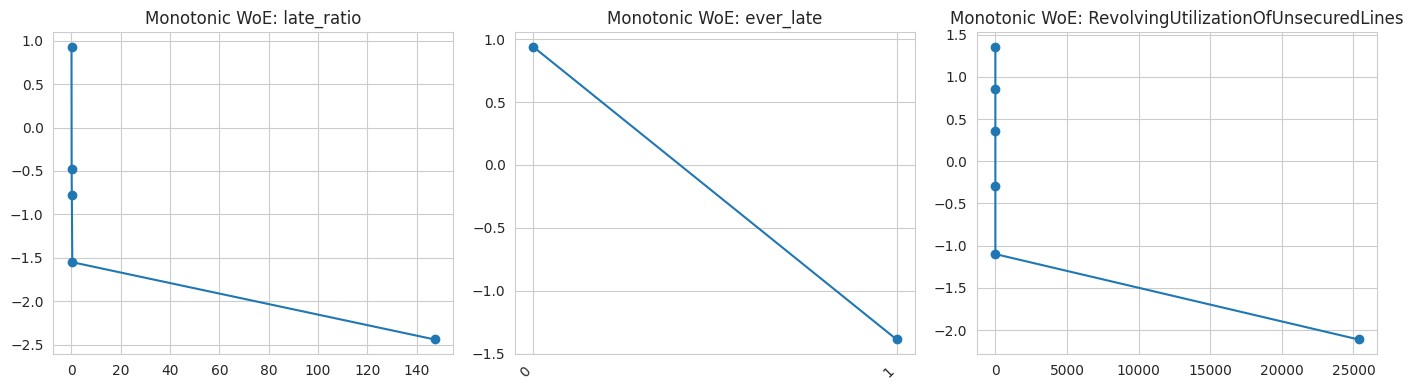

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Logistic regression on WoE features + scorecard

# Visual confirmation of monotonic WoE for top IV features
plt.figure(figsize=(14, 4))
for i, feat in enumerate(sorted(iv_values, key=iv_values.get, reverse=True)[:3]):
  bins_df = woe_bins[feat]
  if bins_df.empty:
    continue
  if bins_df['categorical'].iloc[0]:
    x_vals = range(len(bins_df))
    x_label = bins_df['bin'].astype(str)
  else:
    x_vals = [(l + r) / 2 for l, r in zip(bins_df['left'], bins_df['right'])]
    x_label = None
  plt.subplot(1, 3, i+1)
  plt.plot(x_vals, bins_df['woe'], marker='o')
  plt.title(f'Monotonic WoE: {feat}')
  if x_label is not None and len(x_label) < 15:
    plt.xticks(x_vals, x_label, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Baseline logistic regression
logit = LogisticRegression(max_iter=200, solver='lbfgs')
res_baseline = evaluate_model(logit, X_train, y_train, X_test, y_test, name='Logit_WoE')

# Scorecard construction
coeffs = pd.Series(logit.coef_[0], index=X_train.columns)
intercept = logit.intercept_[0]
pdo = 20
target_score = 600
target_odds = 50
factor = pdo / np.log(2)
offset = target_score - factor * np.log(target_odds)

n_feat = len(coeffs)

def score_single(row):
  contrib = coeffs * row
  per_feature_score = (contrib + intercept / n_feat) * factor + offset / n_feat
  return per_feature_score.sum()

scores_test = X_test.apply(score_single, axis=1)
print('Score summary (test):')
print(scores_test.describe())

plt.figure(figsize=(8, 4))
sns.histplot(scores_test, bins=40, kde=True, color='teal')
plt.title('Scorecard distribution (test set)')
plt.xlabel('Score')
plt.show()


Conduct a sample stability analysis using PSI
- Compare the test and training samples you downloaded from Kaggle (df_train, df_test)

In [ ]:
# PSI (Population Stability Index) between training and Kaggle hold-out sample

def psi(expected: pd.Series, actual: pd.Series, bins: int = 10):
  expected = expected.copy()
  actual = actual.copy()
  quantiles = np.linspace(0, 1, bins + 1)
  cuts = expected.quantile(quantiles).values
  cuts = np.unique(cuts)
  if len(cuts) <= 2:
    return 0.0
  expected_bins = pd.cut(expected, bins=cuts, include_lowest=True, duplicates='drop')
  actual_bins = pd.cut(actual, bins=cuts, include_lowest=True, duplicates='drop')
  exp_pct = expected_bins.value_counts(normalize=True)
  act_pct = actual_bins.value_counts(normalize=True)
  aligned = pd.concat([exp_pct, act_pct], axis=1).fillna(1e-6)
  aligned.columns = ['expected', 'actual']
  psi_val = ((aligned['actual'] - aligned['expected']) * np.log(aligned['actual'] / aligned['expected'])).sum()
  return psi_val

# align df_test with same preprocessing
if 'Unnamed: 0' in df_test.columns:
  df_test = df_test.drop(columns=['Unnamed: 0'])

df_test_proc = df_test.copy()
df_test_proc['MonthlyIncome'].fillna(income_median, inplace=True)
df_test_proc['NumberOfDependents'].fillna(dependents_mode, inplace=True)
# engineered columns on test
_dfq_t = df_test_proc[['NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse']].sum(axis=1)
lines_t = df_test_proc['NumberOfOpenCreditLinesAndLoans'].replace(0, 1)
df_test_proc['log_income'] = np.log1p(df_test_proc['MonthlyIncome'])
df_test_proc['income_per_person'] = df_test_proc['MonthlyIncome'] / (df_test_proc['NumberOfDependents'] + 1)
df_test_proc['debt_to_income'] = df_test_proc['DebtRatio']
df_test_proc['late_ratio'] = _dfq_t / lines_t
df_test_proc['util_times_income'] = df_test_proc['RevolvingUtilizationOfUnsecuredLines'] * df_test_proc['MonthlyIncome']
df_test_proc['ever_late'] = (_dfq_t > 0).astype(int)

psi_results = {}
for col in [c for c in df_fe.columns if c in df_test_proc.columns and c != target]:
  psi_results[col] = psi(df_fe[col].fillna(df_fe[col].median()), df_test_proc[col].fillna(df_fe[col].median()), bins=10)

print('PSI values (top drift first):')
for k, v in sorted(psi_results.items(), key=lambda x: x[1], reverse=True)[:10]:
  print(f'{k}: {v:.4f}')



# 4. Using methods to reduce class imbalance - (Task weight: 20%)
- Try several methods to reduce class imbalance
- Choose the one that brings the greatest improvement

In [ ]:
# -----------------------------
# 4. Imbalance handling experiments
# -----------------------------

results = []

# 1) class_weight balanced
logit_bal = LogisticRegression(max_iter=200, solver='lbfgs', class_weight='balanced')
results.append(evaluate_model(logit_bal, X_train, y_train, X_test, y_test, name='Logit_class_weight'))

# 2) SMOTE + Logistic Regression
smote = SMOTE(random_state=random_state, sampling_strategy=0.3)
logit_smote = LogisticRegression(max_iter=200, solver='lbfgs')
smote_pipe = ImbPipeline(steps=[('smote', smote), ('model', logit_smote)])
results.append(evaluate_model(smote_pipe, X_train, y_train, X_test, y_test, name='SMOTE+Logit'))

# 3) Random undersampling + Logistic
under = RandomUnderSampler(random_state=random_state)
logit_under = LogisticRegression(max_iter=200, solver='lbfgs')
under_pipe = ImbPipeline(steps=[('under', under), ('model', logit_under)])
results.append(evaluate_model(under_pipe, X_train, y_train, X_test, y_test, name='Under+Logit'))

print('\nModel comparison (sorted by ROC-AUC):')
for r in sorted(results, key=lambda x: x['roc_auc'], reverse=True):
  print(r)


_Optional, for those who have reached the end of the laptop_ 😊

What was your impression of the work?
What was difficult?
What was interesting?